# IUM 25L - Projekt
Base model

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pprint

from nocarz.config import PROCESSED_DATA_DIR, MODELS_DIR, NUMERICAL_TARGETS, CATEGORICAL_TARGETS
from nocarz.src.base_model import BaseModel

### Preparing the data

In [2]:
train_data = pd.read_csv(PROCESSED_DATA_DIR / 'train.csv')
test_data = pd.read_csv(PROCESSED_DATA_DIR / 'test.csv')

### Training the model

In [3]:
base_model = BaseModel(data=train_data)
base_model.save(MODELS_DIR / "base_model.pkl")

### Making predictions

In [4]:
results = []

for idx, row in test_data.iterrows():
    host_id = row['host_id']
    predictions, data_type = base_model.predict(host_id)

    actual_values = row.to_dict()
    evaluation = BaseModel.evaluate_predictions(predictions, actual_values)

    result = {
        'listing_id': idx,
        'host_id': host_id,
        'data_type': data_type,
        'predictions': predictions,
        'evaluation': evaluation
    }
    results.append(result)

### Calculating the metrics

In [5]:
metrics = {}

for col in NUMERICAL_TARGETS:
    errors = []
    for result in results:
        if col in result['evaluation'] and result['evaluation'][col]['type'] == 'numerical':
            errors.append(result['evaluation'][col]['error'])

    if errors:
        metrics[col] = {
            'mean_absolute_error': np.mean(errors),
            'median_absolute_error': np.median(errors),
            'count': len(errors)
        }

for col in CATEGORICAL_TARGETS:
    matches = []
    for result in results:
        if col in result['evaluation'] and result['evaluation'][col]['type'] == 'categorical':
            matches.append(result['evaluation'][col]['match'])

    if matches:
        metrics[col] = {
            'accuracy': np.mean(matches),
            'count': len(matches)
        }

pprint.pprint(metrics)

{'accommodates': {'count': 552,
                  'mean_absolute_error': np.float64(0.8768115942028986),
                  'median_absolute_error': np.float64(0.0)},
 'bathrooms': {'count': 405,
               'mean_absolute_error': np.float64(0.20493827160493827),
               'median_absolute_error': np.float64(0.0)},
 'bathrooms_text': {'accuracy': np.float64(0.625), 'count': 552},
 'bedrooms': {'count': 499,
              'mean_absolute_error': np.float64(0.42685370741482964),
              'median_absolute_error': np.float64(0.0)},
 'beds': {'count': 404,
          'mean_absolute_error': np.float64(0.6262376237623762),
          'median_absolute_error': np.float64(0.0)},
 'price': {'count': 405,
           'mean_absolute_error': np.float64(53.21111111111111),
           'median_absolute_error': np.float64(27.5)},
 'property_type': {'accuracy': np.float64(0.6521739130434783), 'count': 552},
 'room_type': {'accuracy': np.float64(0.7644927536231884), 'count': 552}}


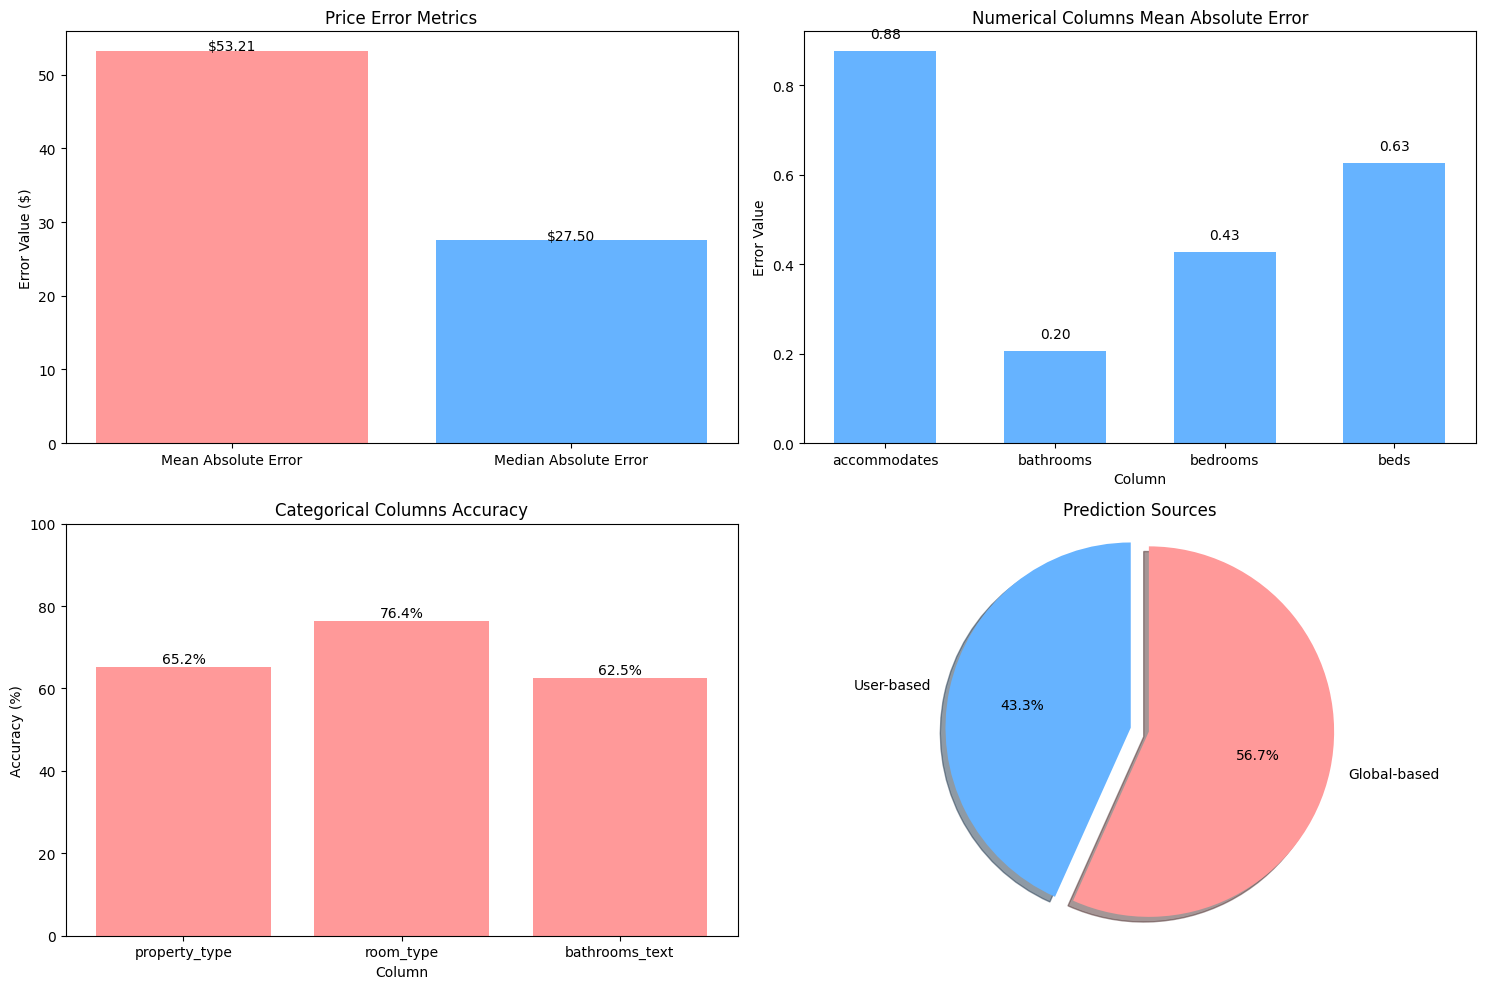


MODEL EVALUATION RESULTS SUMMARY
User-based predictions: 239 (43.3%)
Global-based predictions: 313 (56.7%)
Total predictions: 552


In [6]:
RED = '#ff9999'
BLUE = '#66b3ff'

user_predictions = sum(1 for result in results if result['data_type'] == 'user')
global_predictions = sum(1 for result in results if result['data_type'] == 'global')

# 1. Create a subplot for price MAE
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(221)
if 'price' in metrics:
    price_mae = metrics['price']['mean_absolute_error']
    price_median_ae = metrics['price']['median_absolute_error']

    ax1.bar([0, 1], [price_mae, price_median_ae], color=[RED, BLUE])
    ax1.set_title('Price Error Metrics')
    ax1.set_ylabel('Error Value ($)')
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Mean Absolute Error', 'Median Absolute Error'])
    for i, v in enumerate([price_mae, price_median_ae]):
        ax1.text(i, v + 0.1, f"${v:.2f}", ha='center')

# 2. Create a subplot for numerical columns MAE
ax2 = fig.add_subplot(222)
int_cols = [col for col in NUMERICAL_TARGETS if col in metrics and col != 'price']
mae_values = [metrics[col]['mean_absolute_error'] for col in int_cols]

x = np.arange(len(int_cols))
if int_cols:
    ax2.bar(x, mae_values, color=BLUE, width=0.6)
    ax2.set_title('Numerical Columns Mean Absolute Error')
    ax2.set_xlabel('Column')
    ax2.set_ylabel('Error Value')
    ax2.set_xticks(x)
    ax2.set_xticklabels(int_cols)
    for i, v in enumerate(mae_values):
        ax2.text(i, v + 0.03, f"{v:.2f}", ha='center')

# 3. Create a subplot for categorical accuracy
ax3 = fig.add_subplot(223)
cat_cols = [col for col in CATEGORICAL_TARGETS if col in metrics]
accuracy_values = [metrics[col]['accuracy'] * 100 for col in cat_cols]
if cat_cols:
    ax3.bar(cat_cols, accuracy_values, color=RED)
    ax3.set_title('Categorical Columns Accuracy')
    ax3.set_xlabel('Column')
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_ylim(0, 100)
    for i, v in enumerate(accuracy_values):
        ax3.text(i, v + 1, f"{v:.1f}%", ha='center')

# 4. Create a pie chart for prediction sources
ax4 = fig.add_subplot(224)
labels = ['User-based', 'Global-based']
sizes = [user_predictions, global_predictions]
colors = [BLUE, RED]
explode = (0.1, 0)
ax4.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax4.axis('equal')
ax4.set_title('Prediction Sources')
plt.tight_layout()
plt.show()

# Print a simple summary of the results
print("\n" + "="*60)
print("MODEL EVALUATION RESULTS SUMMARY")
print("="*60)
print(f"User-based predictions: {user_predictions} ({user_predictions/len(results):.1%})")
print(f"Global-based predictions: {global_predictions} ({global_predictions/len(results):.1%})")
print(f"Total predictions: {len(results)}")